In [1]:
!pip install split-folders

In [2]:
import os
import random
import splitfolders

import numpy as np
import pandas as pd

import cv2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from sklearn.metrics import classification_report , accuracy_score
from tensorflow.keras.models import Sequential,model_from_json
from tensorflow.keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPooling2D,BatchNormalization,ReLU,Softmax
from tensorflow.keras.optimizers import Adam,Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy

import warnings
warnings.filterwarnings("ignore")

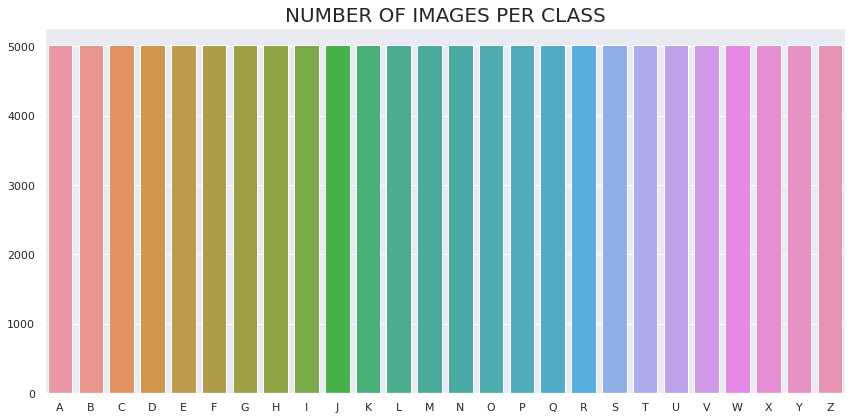

In [3]:
dir_path = '../input/computer-generated-alphabet-dataset/Dataset'
counts = {}
image_sample = {}
for i in sorted(os.listdir(dir_path)) :
    dir = f'{dir_path}/{i}'
    counts[i] = len(os.listdir(dir))
    image_sample[i] = os.listdir(dir)[np.random.randint(counts[i])]

plt.figure(figsize=(12,6))
sns.barplot(x = list(counts.keys()) , y = list(counts.values()));
plt.title('NUMBER OF IMAGES PER CLASS' , fontsize=20)
plt.tight_layout()

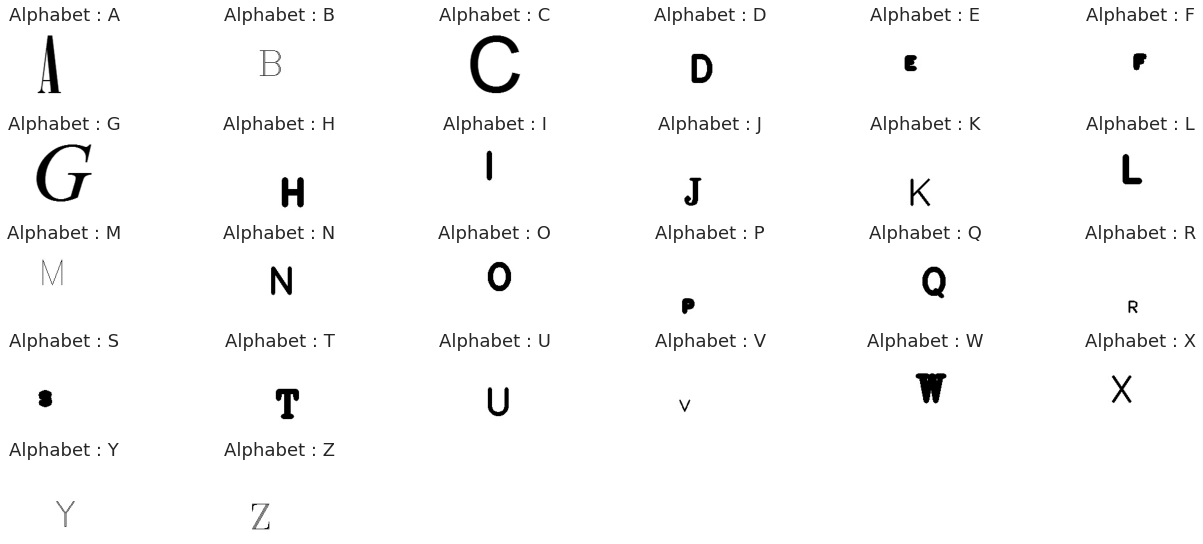

In [4]:
plt.figure(figsize=(18,8))
classes = sorted(os.listdir(dir_path))

for i in range(26) :
    plt.subplot(5,6,i+1)
    plt.tight_layout()        
    img = cv2.imread(f'{dir_path}/{str(classes[i])}/{image_sample[str(classes[i])]}')
    plt.imshow(img, cmap='gray')
    plt.title(f'Alphabet : {classes[i]}' , fontsize=18)
    plt.xticks([])
    plt.yticks([])

In [5]:
input_path = '../input/computer-generated-alphabet-dataset/Dataset'
output_path = './Data'

splitfolders.ratio(input_path, output=output_path, seed=1669,ratio=(.8, .2), group_prefix=None)

Copying files: 130416 files [09:42, 224.01 files/s]


In [6]:
TRAIN_PATH = './Data/train'
VAL_PATH = './Data/val'

CLASSES = sorted(os.listdir(dir_path))

IMAGE_SIZE = 32
MODEL_COUNT = 1
BATCH_SIZE = 1024

In [7]:
TRAIN_DATAGEN = ImageDataGenerator(
    rescale=1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.3,
    zoom_range = 0.3,
    rotation_range = 10
)
VAL_DATAGEN = ImageDataGenerator(
    rescale=1./255
)

TRAIN_SET = TRAIN_DATAGEN.flow_from_directory(
    directory = TRAIN_PATH ,
    target_size = (IMAGE_SIZE , IMAGE_SIZE) ,
    color_mode = 'grayscale' ,
    batch_size = BATCH_SIZE ,
    class_mode = 'categorical' ,
    shuffle = True
)
VAL_SET = VAL_DATAGEN.flow_from_directory(
    directory = VAL_PATH ,
    target_size = (IMAGE_SIZE , IMAGE_SIZE) ,
    color_mode = 'grayscale' ,
    batch_size = BATCH_SIZE ,
    class_mode = 'categorical' ,
    shuffle = False
)

Found 104312 images belonging to 26 classes.
Found 26104 images belonging to 26 classes.


In [8]:
EARLY_STOPPING = EarlyStopping(monitor = 'val_loss' , mode = 'min' , verbose = 1 , patience = 5)
REDUCE_LR_ON_PLATEAU = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3 , verbose = 1 , factor = 0.5 , min_lr = 0.0000001)

CALLBACKS = [EARLY_STOPPING , REDUCE_LR_ON_PLATEAU]

In [11]:
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(5,5),kernel_initializer='he_uniform',padding='same',input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(5,5),kernel_initializer='he_uniform',padding='same'))
model.add(ReLU())
model.add(Conv2D(filters=64,kernel_size=(5,5),kernel_initializer='he_uniform',padding='same'))
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(5,5),kernel_initializer='he_uniform',padding='same'))
model.add(ReLU())
model.add(Conv2D(filters=128,kernel_size=(5,5),kernel_initializer='he_uniform',padding='same'))
model.add(ReLU())
model.add(Conv2D(filters=128,kernel_size=(5,5),kernel_initializer='he_uniform',padding='same'))
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=256,kernel_initializer = 'he_uniform'))
model.add(ReLU())
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(units=128,kernel_initializer = 'he_uniform'))
model.add(ReLU())
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(units=64,kernel_initializer = 'he_uniform'))
model.add(ReLU())
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(units=26,kernel_initializer='glorot_uniform'))
model.add(Softmax())

model.compile(loss=categorical_crossentropy,optimizer=Adam(),metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
re_lu_9 (ReLU)               (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
re_lu_10 (ReLU)              (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)       

In [12]:
history = model.fit(
    TRAIN_SET , 
    steps_per_epoch = TRAIN_SET.n // TRAIN_SET.batch_size , 
    epochs = 100 , 
    validation_data = VAL_SET , 
    validation_steps = VAL_SET.n // VAL_SET.batch_size , 
    verbose = 1 , 
    callbacks = CALLBACKS
)

scores = model.evaluate(VAL_SET)
print(f'Loss : {scores[0]}')
print(f'Accuracy : {scores[1]}')

Epoch 1/100
101/101 [==============================] - 92s 894ms/step - loss: 3.5914 - accuracy: 0.0504 - val_loss: 10.6469 - val_accuracy: 0.0392
Epoch 2/100
101/101 [==============================] - 90s 889ms/step - loss: 2.5607 - accuracy: 0.2186 - val_loss: 10.5329 - val_accuracy: 0.0393
Epoch 3/100
101/101 [==============================] - 90s 893ms/step - loss: 1.4163 - accuracy: 0.5883 - val_loss: 3.4506 - val_accuracy: 0.2271
Epoch 4/100
101/101 [==============================] - 90s 890ms/step - loss: 0.8808 - accuracy: 0.7640 - val_loss: 0.7637 - val_accuracy: 0.7875
Epoch 5/100
101/101 [==============================] - 91s 893ms/step - loss: 0.6787 - accuracy: 0.8224 - val_loss: 0.3607 - val_accuracy: 0.8963
Epoch 6/100
101/101 [==============================] - 90s 885ms/step - loss: 0.5661 - accuracy: 0.8509 - val_loss: 0.3481 - val_accuracy: 0.9055
Epoch 7/100
101/101 [==============================] - 91s 895ms/step - loss: 0.5188 - accuracy: 0.8623 - val_loss: 0.3347

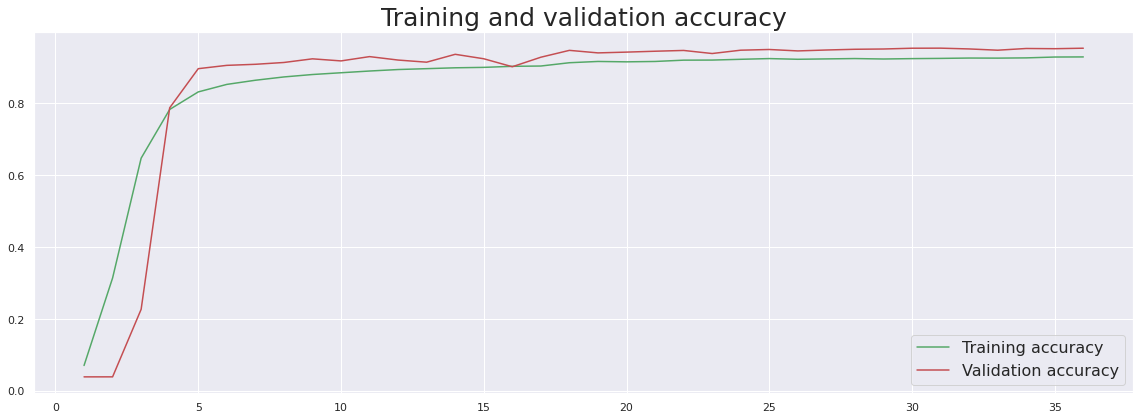

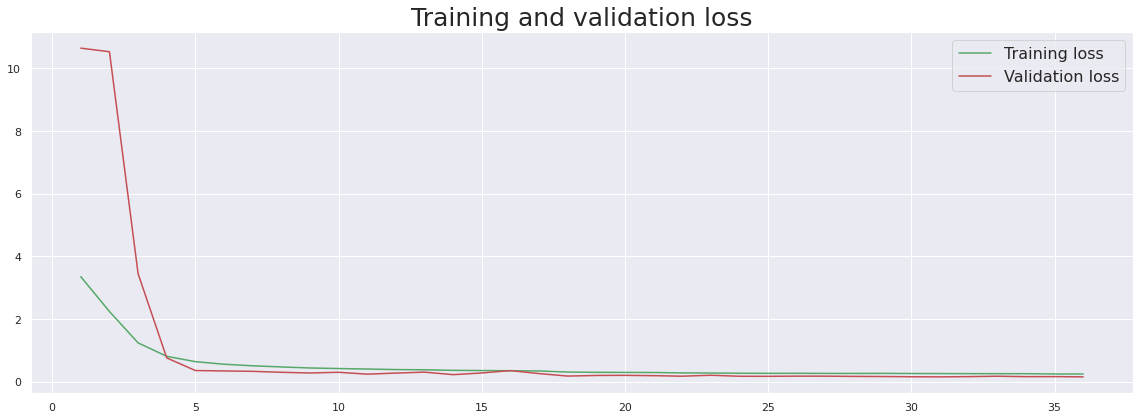

In [13]:
result = pd.DataFrame(history.history)

acc = result['accuracy']
val_acc = result['val_accuracy']
loss = result['loss']
val_loss = result['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(16,6))
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy', fontsize=25)
plt.legend(fontsize=16)
plt.tight_layout()

plt.figure(figsize=(16,6))
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss', fontsize=25)
plt.legend(fontsize=16)
plt.tight_layout()

plt.show()

In [14]:
test_steps_per_epoch = np.math.ceil(VAL_SET.samples / VAL_SET.batch_size)

predictions = model.predict(VAL_SET, steps=test_steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = VAL_SET.classes
class_labels = list(VAL_SET.class_indices.keys()) 

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('CLASSIFICATION REPORT : MODEL')
print(report)

CLASSIFICATION REPORT : MODEL
              precision    recall  f1-score   support

           A       0.99      0.99      0.99      1004
           B       0.98      0.94      0.96      1004
           C       0.96      0.96      0.96      1004
           D       0.98      0.94      0.96      1004
           E       0.99      0.92      0.95      1004
           F       0.97      0.95      0.96      1004
           G       0.96      0.96      0.96      1004
           H       0.93      0.94      0.93      1004
           I       0.76      0.98      0.86      1004
           J       0.90      0.97      0.93      1004
           K       0.97      0.97      0.97      1004
           L       0.94      0.94      0.94      1004
           M       0.97      0.94      0.96      1004
           N       0.98      0.90      0.94      1004
           O       0.94      0.94      0.94      1004
           P       0.98      0.96      0.97      1004
           Q       0.97      0.94      0.95      10

In [15]:
model_name = 'Model(93.48)'
model_json = model.to_json()
with open(f"{model_name}.json", "w") as json_file:
    json_file.write(model_json)
print('Model Saved')
model.save_weights(f"{model_name}.h5")
print('Weights Saved')

Model Saved
Weights Saved


In [16]:
def prepare_data(filepath):
    IMG_SIZE = 32
    img_array = cv2.imread(filepath, cv2. IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    new_array = new_array / 255.
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [17]:
test_path = '../input/testing-images/Test'
images = []
labels = []
predictions = []

for dir in os.listdir(test_path) :
    sub_dir = f'{test_path}/{dir}'
    for img_name in os.listdir(sub_dir) :
        img_path = f'{sub_dir}/{img_name}'
        img = prepare_data(img_path)
        pred = CLASSES[int(np.argmax(model.predict([img])[0]))]
        images.append(img)
        labels.append(str(dir))
        predictions.append(str(pred))
        
acc = np.round(accuracy_score(labels,predictions) * 100 , 2)
print(f'Test Accuracy : {acc}%')

Test Accuracy : 99.49%


In [18]:
errors = 0
error_pred = []
correct_pred = []
img_list = []
for i in range(len(labels)) :
    if labels[i] != predictions[i] :
        errors += 1
        img_list.append(images[i])
        error_pred.append(predictions[i])
        correct_pred.append(labels[i])
print(f'Number of Misclassifications - {str(errors)}')

Number of Misclassifications - 4


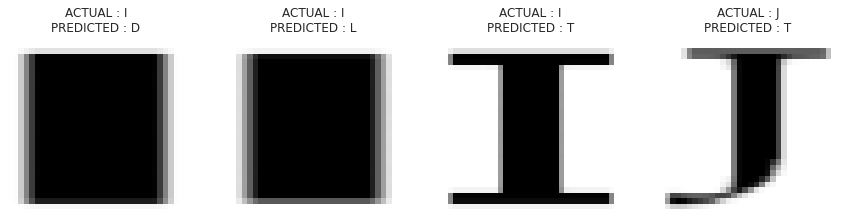

In [19]:
plt.figure(figsize=(12,5))
for i in range(len(correct_pred)) :
    plt.subplot(1,4,i+1)
    plt.tight_layout()
    img = img_list[i][0]
    label = correct_pred[i]
    pred = error_pred[i]
    plt.imshow(img,cmap = 'gray')
    plt.title(f'ACTUAL : {str(label)}\nPREDICTED : {str(pred)}' , fontsize=12)
    plt.xticks([])
    plt.yticks([])

### STACKING MODELS

In [21]:
model_dir = '../input/models-alp'
model_names = ['Model(97.09)','Model(97.64)','Model(98.79)','Model(98.94)',
               'Model(95.95)','Model(93.43)', 'Model(93.48)']
models = []
count = 1

for m in model_names :
    json_file = open(f'{model_dir}/{m}.json','r')
    model_json = json_file.read()
    json_file.close()
    model_ = model_from_json(model_json)
    model_.load_weights(f'{model_dir}/{m}.h5')
    print(f'Model {count} : Loaded')
    count += 1
    models.append(model_)

Model 1 : Loaded
Model 2 : Loaded
Model 3 : Loaded
Model 4 : Loaded
Model 5 : Loaded
Model 6 : Loaded
Model 7 : Loaded


In [22]:
test_steps_per_epoch = np.math.ceil(VAL_SET.samples / VAL_SET.batch_size)

predictions = [model.predict(VAL_SET, steps=test_steps_per_epoch) for model in models]
predictions=np.array(predictions)
summed = np.sum(predictions, axis=0)
predicted_classes = np.argmax(summed, axis=1)
true_classes = VAL_SET.classes
class_labels = list(VAL_SET.class_indices.keys()) 

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('CLASSIFICATION REPORT : MODEL')
print(report)

CLASSIFICATION REPORT : MODEL
              precision    recall  f1-score   support

           A       1.00      0.99      0.99      1004
           B       0.97      0.96      0.97      1004
           C       0.96      0.97      0.96      1004
           D       0.98      0.96      0.97      1004
           E       0.98      0.93      0.95      1004
           F       0.95      0.95      0.95      1004
           G       0.97      0.96      0.97      1004
           H       0.95      0.94      0.95      1004
           I       0.71      0.98      0.82      1004
           J       0.95      0.96      0.95      1004
           K       0.97      0.97      0.97      1004
           L       0.94      0.94      0.94      1004
           M       0.98      0.94      0.96      1004
           N       0.98      0.93      0.96      1004
           O       0.96      0.95      0.95      1004
           P       0.99      0.97      0.98      1004
           Q       0.98      0.95      0.96      10

In [24]:
test_path = '../input/testing-images/Test'
images = []
labels = []
predictions = []

for dir in os.listdir(test_path) :
    sub_dir = f'{test_path}/{dir}'
    for img_name in os.listdir(sub_dir) :
        img_path = f'{sub_dir}/{img_name}'
        img = prepare_data(img_path)
        preds = [model.predict([img])[0] for model in models]
        preds=np.array(preds)
        summed = np.sum(preds, axis=0)
        pred = CLASSES[int(np.argmax(summed))]
        images.append(img)
        labels.append(str(dir))
        predictions.append(str(pred))
        
acc = np.round(accuracy_score(labels,predictions) * 100 , 2)
print(f'Test Accuracy : {acc}%')

Test Accuracy : 99.87%


In [25]:
errors = 0
error_pred = []
correct_pred = []
img_list = []
for i in range(len(labels)) :
    if labels[i] != predictions[i] :
        errors += 1
        img_list.append(images[i])
        error_pred.append(predictions[i])
        correct_pred.append(labels[i])
print(f'Number of Misclassifications - {str(errors)}')

Number of Misclassifications - 1


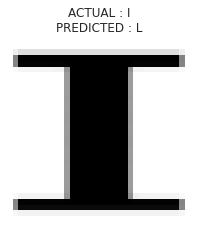

In [28]:
plt.figure(figsize=(12,5))
for i in range(len(correct_pred)) :
    plt.subplot(1,4,i+1)
    plt.tight_layout()
    img = img_list[i][0]
    label = correct_pred[i]
    pred = error_pred[i]
    plt.imshow(img,cmap = 'gray')
    plt.title(f'ACTUAL : {str(label)}\nPREDICTED : {str(pred)}' , fontsize=12)
    plt.xticks([])
    plt.yticks([])